In [1]:
import os
os.environ["CONDA_PREFIX"] = "/opt/conda" if os.path.exists("/opt/conda") else '/usr/local'
!pip install uv
!uv pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 81.1 MB/s eta 0:00:00
Resolved 17 packages in 231ms
Downloaded 6 packages in 395ms
Installed 6 packages in 21ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifacts/pillow_1712154467551/work)
 + pillow==9.5.0
 - pyparsing==3.1.1
 - pyparsing==3.1.2 (from file:///home/conda/feedstock_root/build_artifacts/pyparsing_1709721012883/work)
 + pyparsing==3.1.1
 + pyswarms==1.3.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface

# Data

In [3]:
data = pd.read_csv(
    "diabetes_prediction_dataset.csv" 
    if os.path.exists("diabetes_prediction_dataset.csv") 
    else "/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv"
)

In [4]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
data["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [7]:
data = data[data["smoking_history"] != "No Info"]

In [8]:
data["gender"].value_counts()

gender
Female    38852
Male      25320
Other        12
Name: count, dtype: int64

In [9]:
data = data[data["gender"] != 'Other']

In [10]:
data["gender"] = data["gender"].map({"Male": 1, "Female": 0})

In [11]:
data["gender"] = data["gender"].astype(int)

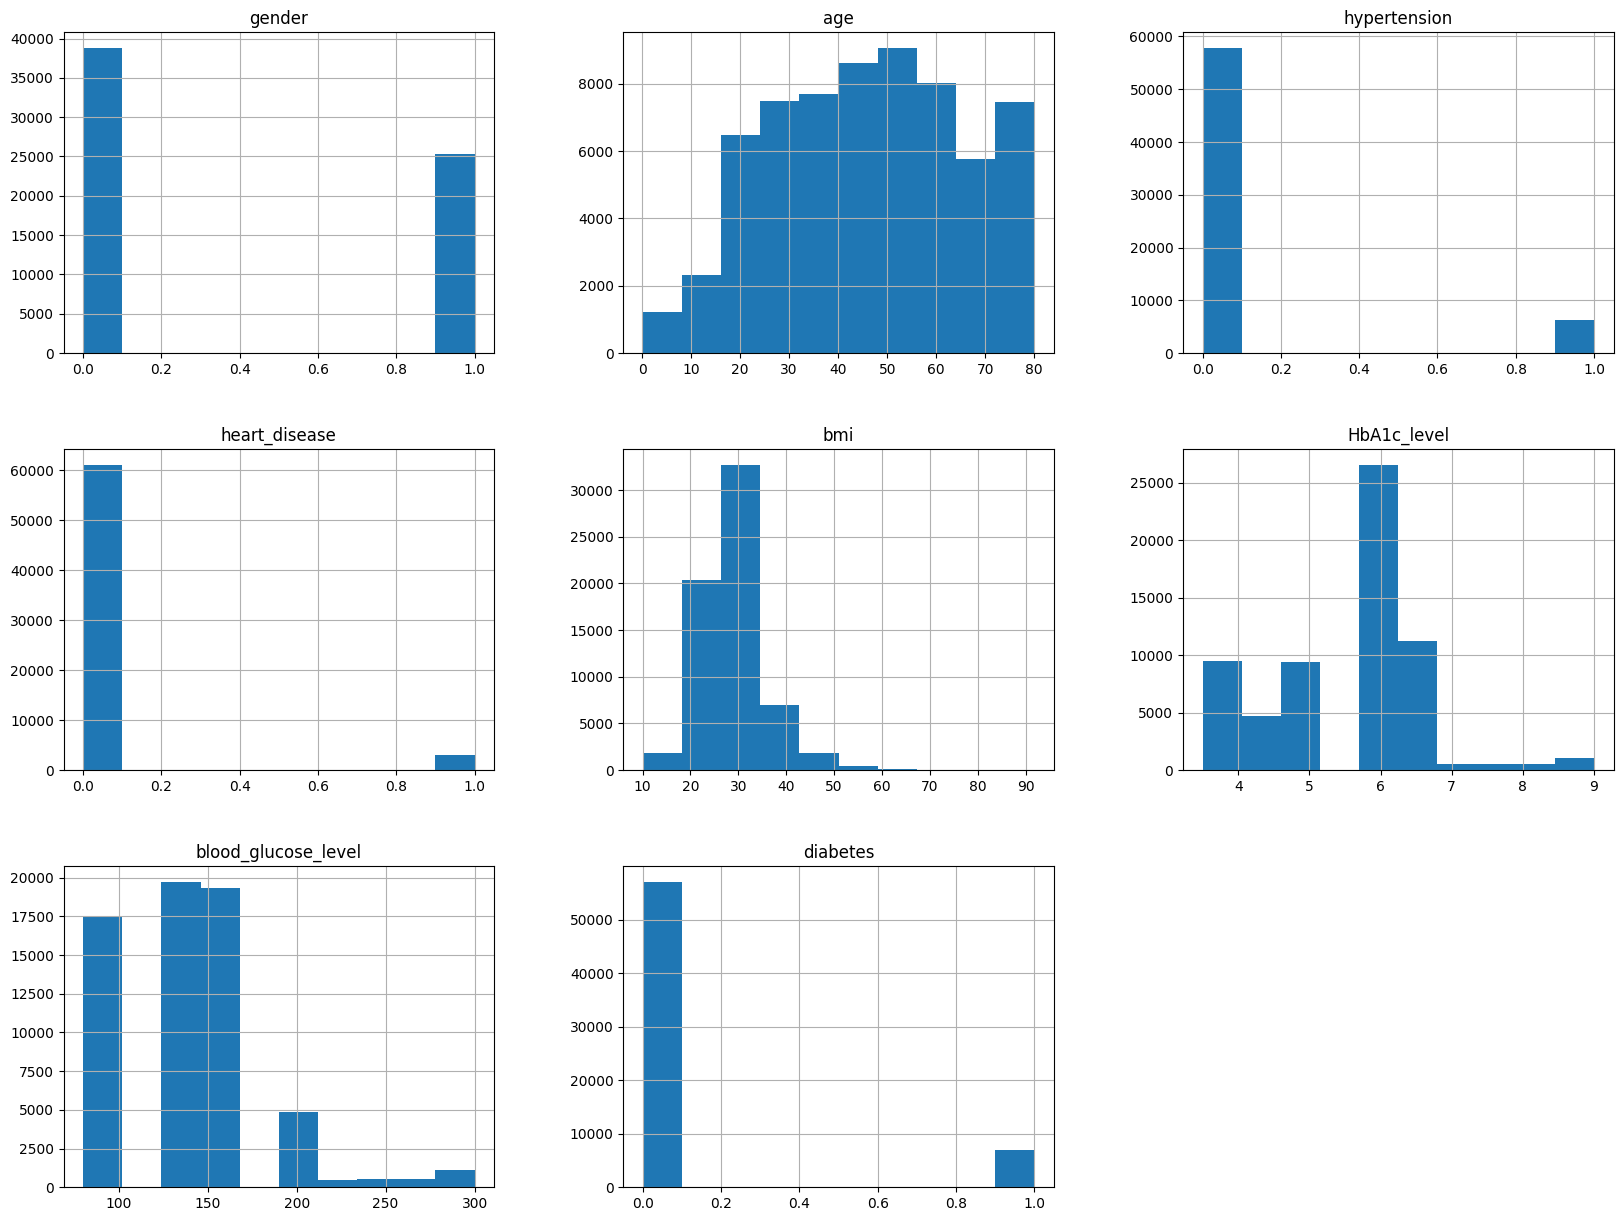

In [12]:
data.hist(figsize=(20, 15))
plt.show()

In [13]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [14]:
data.duplicated().sum()

925

In [15]:
data = data.drop_duplicates()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63247 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               63247 non-null  int64  
 1   age                  63247 non-null  float64
 2   hypertension         63247 non-null  int64  
 3   heart_disease        63247 non-null  int64  
 4   smoking_history      63247 non-null  object 
 5   bmi                  63247 non-null  float64
 6   HbA1c_level          63247 non-null  float64
 7   blood_glucose_level  63247 non-null  int64  
 8   diabetes             63247 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 4.8+ MB


In [17]:
data = pd.get_dummies(data, columns=["smoking_history"])

In [18]:
x = data.drop(["diabetes"], axis=1)
y = data["diabetes"]

In [19]:
x

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,False,False,False,True,False
2,1,28.0,0,0,27.32,5.7,158,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,True,False,False,False,False
5,0,20.0,0,0,27.32,6.6,85,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99992,0,26.0,0,0,34.34,6.5,160,False,False,False,True,False
99993,0,40.0,0,0,40.69,3.5,155,False,False,False,True,False
99997,1,66.0,0,0,27.83,5.7,155,False,False,True,False,False
99998,0,24.0,0,0,35.42,4.0,100,False,False,False,True,False


In [20]:
y

0        0
2        0
3        0
4        0
5        0
        ..
99992    0
99993    0
99997    0
99998    0
99999    0
Name: diabetes, Length: 63247, dtype: int64

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Model

In [22]:
model = LogisticRegression(max_iter=1000)

In [23]:
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
model.score(x_train, y_train)

0.9474159739790387

In [25]:
y_train_pred = model.predict(x_train)

In [26]:
accuracy_score(y_train, y_train_pred)

0.9474159739790387

In [27]:
precision_score(y_train, y_train_pred, average="macro")

0.9082464864132006

In [28]:
recall_score(y_train, y_train_pred, average="macro")

0.8144789650405178

In [29]:
f1_score(y_train, y_train_pred, average="macro")

0.8532788718857967

In [30]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     39226
           1       0.86      0.64      0.74      5046

    accuracy                           0.95     44272
   macro avg       0.91      0.81      0.85     44272
weighted avg       0.94      0.95      0.94     44272



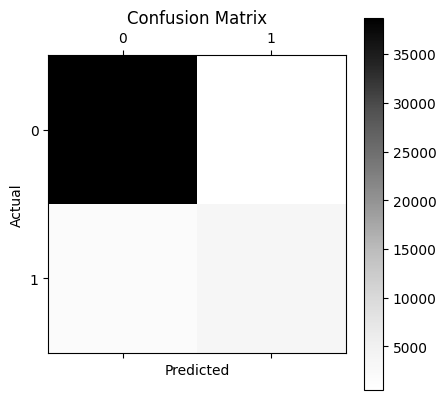

In [31]:
plt.matshow(confusion_matrix(y_train, y_train_pred), cmap="Greys")
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
y_test_pred = model.predict(x_test)

In [33]:
accuracy_score(y_test_pred, y_test)

0.9504084321475625

In [34]:
precision_score(y_test_pred, y_test, average="macro")

0.8148971212424823

In [35]:
recall_score(y_test_pred, y_test, average="macro")

0.9032824161560633

In [36]:
f1_score(y_test_pred, y_test, average="macro")

0.8520278903473544

In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     16984
           1       0.85      0.64      0.73      1991

    accuracy                           0.95     18975
   macro avg       0.90      0.81      0.85     18975
weighted avg       0.95      0.95      0.95     18975



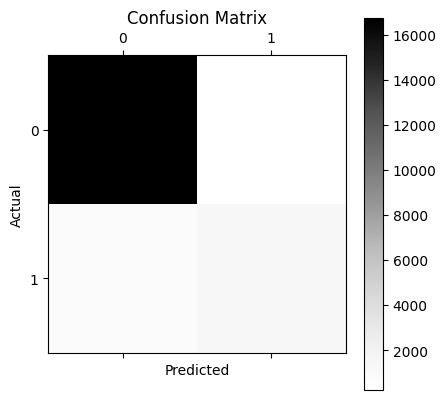

In [38]:
plt.matshow(confusion_matrix(y_test, y_test_pred), cmap="Greys")
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
options = {"c1": 0.5, "c2": 0.3, "w": 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)
cost, pos = optimizer.optimize(fx.sphere, iters=1000)
print(cost, pos)

2024-05-07 18:48:18,879 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.81e-44
2024-05-07 18:48:20,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8065105529165853e-44, best pos: [ 1.03736446e-22 -8.54625955e-23]


1.8065105529165853e-44 [ 1.03736446e-22 -8.54625955e-23]


<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

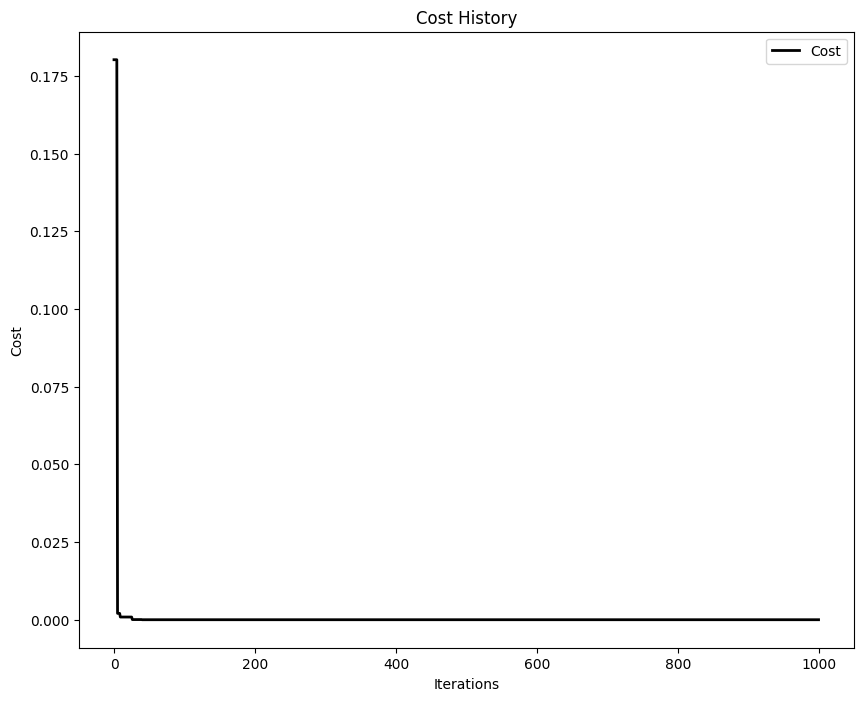

In [40]:
plot_cost_history(optimizer.cost_history)